# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 7: intrinsic rate


## Imports and definitions:

In [1]:
######################################
## Imports
import numpy as np
import h5py as h5

from astropy.table import Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm

from scipy import stats

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# Extra python functions
import HelperFunctions as func

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 


In [2]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
DCO.info()
'''

################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
# DCO['Metallicity@ZAMS(1)']   = File['DoubleCompactObjects']['Metallicity@ZAMS(1)'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])
# DCO['mixture_weight']        = File['DoubleCompactObjects']['mixture_weight'][()]

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
intrinsic_rate_density       = File[rate_key]['merger_rate'][()]
redshifts                    = File[rate_key]['redshifts'][()]

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16

# Filter both the BBH table and the intrinsic rate data
merging_BBH         = DCO[DCO_mask * nonCHE_bool]
Red_intr_rate_dens  = intrinsic_rate_density[rate_nonCHE_bool, :]


../output/COMPAS_Output_wWeights.h5


## SFR(z) Madau & Dickenson 2014 shape

In [3]:

########################################################
##
########################################################
def Madau_Dickinson2014(z, a=0.015, b=2.77, c=2.9, d=5.6):
    """
    default 'Neijssel et al 2019': a=0.01, b=2.77, c=2.9,  d=4.7
    Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2

    """
    dm_dtdMpc = a * (1 + z)**b/( 1 + ( (1+z)/c )**d ) *u.Msun *u.yr**-1 *u.Mpc**-3
    return dm_dtdMpc # Msun year-1 Mpc-3 

    
sf_a_best, sf_b_best, sf_c_best, sf_d_best =0.01687063881834458, 1.4834054063851878, 4.448574027958166, 5.903964702985274 
    

In [8]:

def plot_redshift_dist(table, WEIGHTS, redshift_list = redshifts, alternate_bools = False, show_hist = True, show_SFR=True,
                       show_peak = False, show_fit=True, fill = True, log = False, norm_by_R0 = False,
                       z_firstSF = 10, tmin=0, tmax = 10, x_redshift = True,  bins = np.arange(0,10,0.5), 
                       ylab = '$R_{\mathrm{BBH}} \ \mathrm{[Gpc^{-3} yr^{-1}]}$',
                       SFlab = r'$\mathrm{SFRD(z)/SFRD(}z=0\mathrm{)}$',
                       save_plot = False, save_str = '',zorders = [2,0,1,3],
                       y_lim=(0.1, 1e4), FIGSIZE=(16,8), SFylim = (0,7), SFtext = (0.21,0.6, 55),
                       colors = ['#488496', '#73bdb3', '#e388b0'], hatches = ['/', 'x', 'o']):

    # centers of redshif bins
    center_z = (redshift_list[:-1] + redshift_list[1:])/2.

    ##############################
    Bool_list = [table['M_moreMassive'] <= 10, np.logical_and(table['M_moreMassive'] > 10, table['M_moreMassive'] <= 20), np.logical_and(table['M_moreMassive'] > 20, table['M_moreMassive'] <= 30), table['M_moreMassive'] > 30]
    labels    = ['$\mathrm{M_{BH,1} \leq 10 M_{\odot}} \hspace{3.cm}$',
                 '$\mathrm{10 M_{\odot} > M_{BH,1} \leq 20 M_{\odot}} \hspace{0.5cm}$', 
                 '$\mathrm{ 20 M_{\odot} > M_{BH,1} \leq 30 M_{\odot}} \hspace{0.5cm}$',
                 '$\mathrm{M_{BH,1} > 30 M_{\odot}} \hspace{3.cm}$']

    ##############################
    # plotting stuff
    fig, ax = plt.subplots(figsize = FIGSIZE)

    ##############################
    #### SFR ####
    if show_SFR:
#         y_vals = Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.90,  d=4.70).to(u.Msun *u.yr**-1 *u.Gpc**-3)
        y_vals = Madau_Dickinson2014(redshift_list, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best).to(u.Msun *u.yr**-1 *u.Gpc**-3)
        if norm_by_R0:
            SFnorm = y_vals[0]
        else:
            SFnorm = 1.
        
        ##############################
        if show_fit:
            from scipy.optimize import curve_fit
            
            maxi_fit = 20
            def f(x, A, B): # this is your 'straight line' y=f(x)
                return A*x + B
            popt, pcov = curve_fit(f, center_z[0:maxi_fit], y_vals[0:maxi_fit]/SFnorm) # your data x, y to fit
            perr = np.sqrt(np.diag(pcov)) # 1-sigma error on params
            a_value, a_err = np.round(popt[0],2), np.round(perr[0],2)
            y_z = f(center_z[0:maxi_fit], popt[0],popt[1])
#             ax.plot(center_z[0:maxi_fit], y_z,c = 'orange', zorder=10, lw = 4) 
        
        
        ax.plot(redshift_list, y_vals/SFnorm, label = SFlab+r'\hspace{0.4cm} $a_{\mathrm{SF}}$'+f'$ \ = {a_value} \pm {a_err} $', c = 'grey', lw=3, ls = '--', zorder =10)
        print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', redshift_list[np.argmax(y_vals)])
        # Annotate
        ax.text(x=SFtext[0],y=SFtext[1],s='$\mathrm{SFRD(z)}$',ha = 'left', va = 'bottom', #x=0.39,y=0.59, -40
                   c='grey', rotation =SFtext[2], fontsize=25,transform=plt.gcf().transFigure) #1900600  

    ##############################
    # Add zoom-in inset axis
    axins = ax.inset_axes([0.65, 0.24, 0.29, 0.33]) #[x0, y0, width, height] rel to ax

    ##############################
    # centers of redshif bins
    center_z = (redshift_list[:-1] + redshift_list[1:])/2.

    ##############################
    # Then split by mass/CE bins
    for b, Bool in enumerate(Bool_list):
        
        ##############################
        # Select BHs within a certain mass range
        R_z_for_mass_bin     = np.sum(WEIGHTS[Bool,:], axis = 0)  #/(1+center_z)
        if norm_by_R0:
            norm = R_z_for_mass_bin[0]
        else:
            norm = 1
            
        ########################
        if show_fit:
            maxi_fit = 20
            def f(x, A, B): # this is your 'straight line' y=f(x)
                return A*x + B
            popt, pcov = curve_fit(f, center_z[0:maxi_fit], R_z_for_mass_bin[0:maxi_fit]/norm) # your data x, y to fit
            perr = np.sqrt(np.diag(pcov)) # 1-sigma error on params
            print(f'perr {perr}')
            a_value, a_err = np.round(popt[0],2), np.round(perr[0],2)
            print('popt', popt)
            y_z = f(center_z[0:maxi_fit], popt[0],popt[1])
            ax.plot(center_z[0:maxi_fit], y_z,
                    c = 'orange', zorder=10, lw = 4) 
            if b == 1:
                dy, dx = 0.3, -0.1
                dy_in = 0.3
            else:
                dy, dx =0, 0.1
                dy_in = 0.
            ax.text(center_z[maxi_fit-1]+0.3+ 0.1*(-1)**b, y_z[maxi_fit-1]+dx*(-1)**b +dy,s='$a_{%s}$'%(b+1), color='orange', # y_z[3]+35
                    ha='right', va='bottom', fontsize=30, zorder=50,
                   bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.01'))
            
            ##########################
            # Also plot the zoomed in version
            axins.plot(center_z[0:maxi_fit], y_z, c = 'orange', zorder=10, lw = 4) 
            axins.text(center_z[maxi_fit-1] +0.1, y_z[maxi_fit-1]+dy_in,s='$a_{%s}$'%(b+1), color='orange',
                       ha='left', va='bottom', fontsize=30, zorder=50,bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.005'))
            
        ##############################
        ## And plot the rate as a function of redshift
        ax.plot(center_z, R_z_for_mass_bin/norm, lw=5, color=colors[b], zorder = zorders[b]+1)
        
        ax.fill_between(center_z, y1=0, y2=R_z_for_mass_bin/norm, zorder = zorders[b]+1, alpha = 1, color='white')
        ax.fill_between(center_z, y1=0, y2=R_z_for_mass_bin/norm, zorder = zorders[b]+1, lw = 4,
                        facecolor='none', edgecolor=colors[b],hatch = hatches[b], label = labels[b]+f'$a_{b+1} = {a_value} \pm {a_err} $',)
        
        ##########################
        # Also plot the zoomed in version
        axins.plot(center_z, R_z_for_mass_bin/norm, lw=5, color=colors[b], zorder = zorders[b]+1)
        
        
        ########################
        if show_peak:
            stop_at_y =  0.85*y_lim[-1] - zorders[b]*0.55
            ax.vlines(center_z[np.argmax(R_z_for_mass_bin)], ymin = y_lim[0], ymax = stop_at_y,color='k',#colors[b], 
                      ls=':', lw = 2, zorder = zorders[b] )
            bw = np.diff(bins)[0]
            ax.annotate('$z_{\mathrm{peak} }=%s$'%(np.round(center_z[np.argmax(R_z_for_mass_bin)],1) ), (center_z[np.argmax(R_z_for_mass_bin)]+(0.5*bw), stop_at_y), 
                        ha='right', zorder =  zorders[b]+1, fontsize = 25, color = 'k', #colors[b], 
                        rotation = -20, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.01', alpha = 0.7)  )     

            
            
    ##########################################################################
    #### Age Universe Axis ####
    ax2 = ax.twiny()
    ###################
    if x_redshift:
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find lookback location for each of our redshifts
        redshift_tick_list = [0, 2, 4, 6, 8, 10]
        z_firstSF = 10
        t_firstSF = cosmo.lookback_time(z_firstSF).value
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(t_firstSF - cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{time \ since} \ z=10 \ \mathrm{[Gyr]}$', fontsize = 30, labelpad=15)
    ###################
    else:
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find lookback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30, labelpad=15)
    
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)       

    
    ##############################
    # plot values
    ax.set_ylim(y_lim)
    ax.set_ylabel(ylab, fontsize = 30)
    
    ##############################
    # limit zoom-in inset axis
    axins.set_xlim(0,1.5)
    axins.set_ylim(1.,3.5)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    
    if log:
        ax.set_yscale('log')
    leg = ax.legend(fontsize = 20, facecolor='white', framealpha=0.75)#, title = '$ a_{i} \  \mathrm{[Gpc^{-3} yr^{-1}]}$')
    
#     if show_SFR:
#         SFRax.set_zorder(ax.get_zorder()+2)
#         ax.patch.set_alpha(0.)
        
    if save_plot:
        print('saving ' + save_loc+'/Rate_redshift_'+save_str+'.pdf')
        plt.savefig(save_loc+'/Rate_redshift_'+save_str+'.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/Rate_redshift_'+save_str+'.png', bbox_inches='tight')

    ax.patch.set_visible(False)
#     SFRax.patch.set_visible(False)
    plt.show()




## Normalised by R at z=0

max value 87879729.16713627 solMass / (Gpc3 yr)  at x_max =  2.7
perr [0.02193554 0.01266053]
popt [1.72103337 0.89595162]
perr [0.03779093 0.02181179]
popt [1.92702537 0.85221263]
perr [0.00976974 0.0056388 ]
popt [1.10009372 0.94721832]
perr [0.01129148 0.0065171 ]
popt [0.56115257 1.00974505]
saving ../plots//Rate_redshift_N1e7_Normalized_Rate_source.pdf


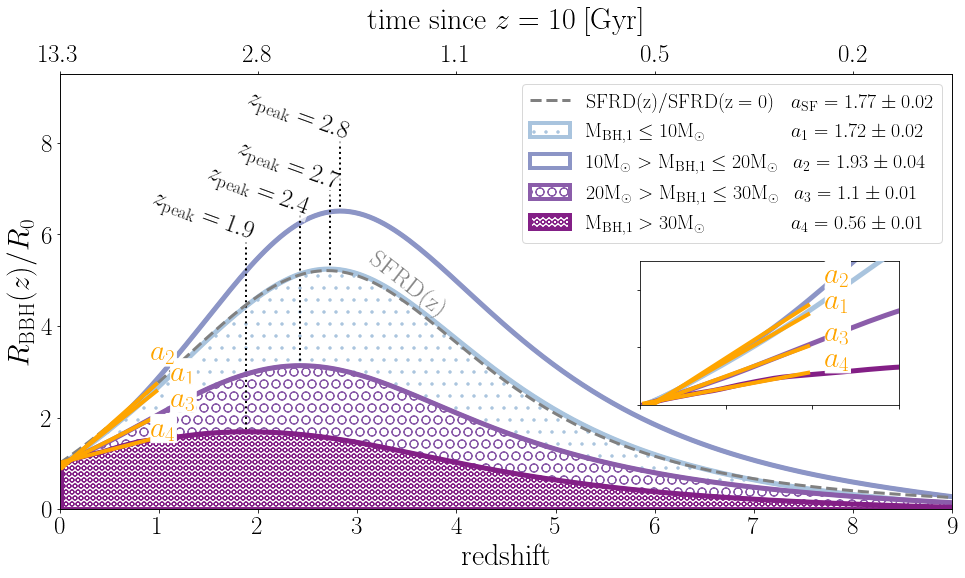

In [9]:
kleuren = sns.color_palette("BuPu", 5)

# Intrinsic rate density (detector frame)
plot_redshift_dist(merging_BBH, Red_intr_rate_dens, redshift_list = redshifts, tmin=0, tmax = 9, show_hist=False, show_SFR=True,
                   show_peak=True, show_fit = True, log=False, norm_by_R0 = True, 
                   y_lim=(0, 9.5),SFylim =(0,9.5), #9.5
                   bins = np.arange(0,10.25,0.25), ylab = '$R_{\mathrm{BBH}}(z)/R_{0}$',#ylab = '$R_{\mathrm{BBH}}(z)/R_{0} \ \mathrm{[Gpc^{-3} yr^{-1}]}$',
                   SFlab = r'$\mathrm{SFRD(z)}/\mathrm{SFRD(z=0)}$',
                   save_plot = True, save_str = sim_save_str+'Normalized_Rate_source', SFtext = (0.39,0.45, -38),#0.59
                   colors = kleuren[1:], hatches = ['.','', 'O', 'OO'],zorders = [2,0,3,4])

